# Communication channel

This example demonstrates how to create a connection
from one neuronal ensemble to another
that behaves like a communication channel
(that is, it transmits information without changing it).

An abstract input signal is fed into a first neuronal ensemble `pre`,
which then passes it on to another ensemble `post`.
The result is that spiking activity in ensemble `post`
encodes the value from the Input.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_loihi

# All NengoLoihi models should call this before model construction
nengo_loihi.set_defaults()

## Creating the network in Nengo

Nengo provides five core objects
for building large scale models.

- `nengo.Ensemble`:
  A group of neurons collectively representing a time-varying vector.
- `nengo.Node`:
  Non-neural aspects of the model, whether it be for input
  (e.g. an artificial input signal or data from a robot sensor),
  output (e.g. to send data to a socket or robot motor),
  or both (e.g. managing interfaces to a robot).
- `nengo.Connection`:
  Connections move information (vectors) from
  one object (e.g. node or ensemble) to another object.
  Connections can also transform vectors linearly or nonlinearly.
- `nengo.Probe`:
  Marks part of the simulation so that it will be recorded.
- `nengo.Network`:
  A container for ensembles, nodes, connections, and probes.
  Networks can also contain subnetworks,
  allowing for hierarchically organized models.

For the communication channel,
we will use all five of these objects.
A node will be used to provide input to an ensemble
through a connection, which will be connected
to another ensemble.
By probing the input node and two ensembles,
we can see that the vector represented by
all three objects is the same,
even though the neuron properties
of the two ensembles differ
and the two ensembles are connected
through connection weights.

In [2]:
with nengo.Network(label="Communication channel") as model:
    stim = nengo.Node(lambda t: np.sin(2 * np.pi * t))

    pre = nengo.Ensemble(n_neurons=80, dimensions=1)
    post = nengo.Ensemble(n_neurons=60, dimensions=1)

    # Connect the stim input to the first ensemble
    nengo.Connection(stim, pre)

    # Connect the first ensemble to the second
    # (this is the communication channel)
    nengo.Connection(pre, post)

    stim_probe = nengo.Probe(stim)
    # Probing an ensemble gives the decoded value
    pre_probe = nengo.Probe(pre, synapse=0.01)
    post_probe = nengo.Probe(post, synapse=0.01)
    # We can also probe their neurons directly to see their firing patterns
    pre_n_probe = nengo.Probe(pre.neurons)
    post_n_probe = nengo.Probe(post.neurons)

## Running the network in Nengo

We can use Nengo to see the desired model output.

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(2.0)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

As we can see below, both `pre` and `post` ensembles
faithfully represent the input signal.

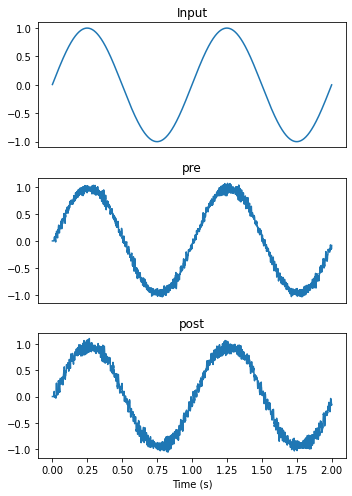

In [4]:
def plot_decoded(t, data):
    plt.figure(figsize=(5, 7))
    plt.subplot(3, 1, 1)
    plt.title("Input")
    plt.plot(t, data[stim_probe])
    plt.xticks(())
    plt.subplot(3, 1, 2)
    plt.title("pre")
    plt.plot(t, data[pre_probe])
    plt.xticks(())
    plt.subplot(3, 1, 3)
    plt.title("post")
    plt.plot(t, data[post_probe])
    plt.xlabel("Time (s)")
    plt.tight_layout()


plot_decoded(t, sim.data)

By looking at their raster plots,
we can see that these are two different ensembles
with different firing activities.
It is the encoding and decoding processes
that allow us to interpret them as representing
the same value.

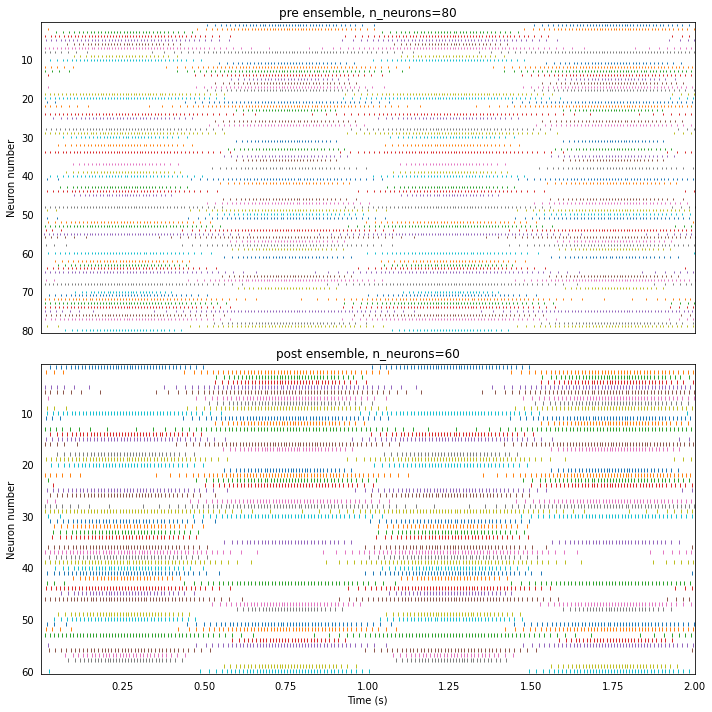

In [5]:
def plot_rasters(t, data):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    rasterplot(t, data[pre_n_probe])
    plt.title("pre ensemble, n_neurons={}".format(pre.n_neurons))
    plt.ylabel("Neuron number")
    plt.xticks(())
    plt.subplot(2, 1, 2)
    rasterplot(t, data[post_n_probe])
    plt.title("post ensemble, n_neurons={}".format(post.n_neurons))
    plt.ylabel("Neuron number")
    plt.xlabel("Time (s)")
    plt.tight_layout()


plot_rasters(t, sim.data)

## Running the network with NengoLoihi

To run the same model on a Loihi board,
we do not need to make any changes to the model itself
(aside from calling the
`nengo_loihi.set_defaults()` function earlier).
The only difference is that instead of using `nengo.Simulator`
to construct and run the model,
we use `nengo_loihi.Simulator`.

In [6]:
with nengo_loihi.Simulator(model, precompute=True) as sim:
    sim.run(2.0)
t = sim.trange()

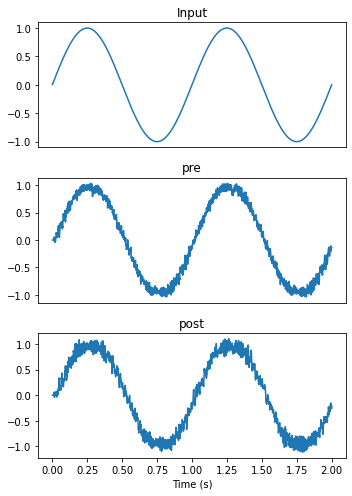

In [7]:
plot_decoded(t, sim.data)

While the `pre` output looks similar
to the output from the Nengo simulator,
`post` is significantly more noisy.
Looking at the spike raster gives some insight
into why that might be the case.

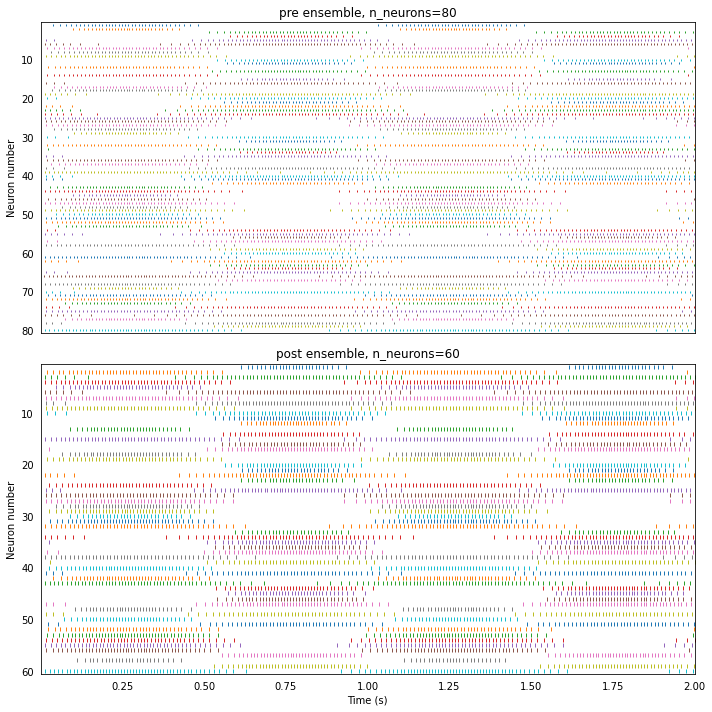

In [8]:
plot_rasters(t, sim.data)

While `pre`'s spike raster resembles that of Nengo's,
we can see in the `post` spike raster
that several neurons have synchronized
(e.g., spikes co-occur for many neurons at just after 0.5 seconds).

This occurs in Loihi but not Nengo because
Nengo's built in simulator keeps track of the
voltage overshoot when a LIF neuron spikes
so that the refractory period can effectively
start and end within a timestep,
instead of always rounding to the earliest timestep.

The issue could be worked around in Loihi
by using a smaller timestep,
or by injecting noise to break the synchrony.